# Convección Rayleigh Bernárd

Dedalus script for 2D Rayleigh-Benard convection.

This script uses a Fourier basis in the x direction with periodic boundary
conditions.  The equations are scaled in units of the buoyancy time (Fr = 1).

Lo voy a tratar de modificar para que la flotabilidad sea una función sólo de la temperatura y se rija por la ecuación calórica.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py 
from dedalus import public as de
from dedalus.extras import flow_tools
import time
from IPython import display
from matplotlib import animation

In [3]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

## Parámetros

In [4]:
# Parameters
Lx, Lz = (4., 1.)
nx, nz = (256, 64)
Prandtl = 1.
Rayleigh = 1e6
ρ0 = 0.99802
α = 8.1e-4
T_b = 5.0

## Bases y dominio

In [5]:
# Create bases and domain
x_basis = de.Fourier('x', nx, interval=(0, Lx), dealias=3/2)
z_basis = de.Chebyshev('z', nz, interval=(-Lz/2, Lz/2), dealias=3/2)
domain = de.Domain([x_basis, z_basis], grid_dtype=np.float64)

Código original
```python
problem = de.IVP(domain, variables=['p','b','u','w','bz','uz','wz'])
problem.meta['p','b','u','w']['z']['dirichlet'] = True
problem.parameters['P'] = (Rayleigh * Prandtl)**(-1/2)
problem.parameters['R'] = (Rayleigh / Prandtl)**(-1/2)
problem.parameters['F'] = F = 1
problem.add_equation("dx(u) + wz = 0")
problem.add_equation("dt(b) - P*(dx(dx(b)) + dz(bz)) - F*w       = -(u*dx(b) + w*bz)")
problem.add_equation("dt(u) - R*(dx(dx(u)) + dz(uz)) + dx(p)     = -(u*dx(u) + w*uz)")
problem.add_equation("dt(w) - R*(dx(dx(w)) + dz(wz)) + dz(p) - b = -(u*dx(w) + w*wz)")
problem.add_equation("bz - dz(b) = 0")
problem.add_equation("uz - dz(u) = 0")
problem.add_equation("wz - dz(w) = 0")

problem.add_bc("left(b) = 0")
problem.add_bc("left(u) = 0")
problem.add_bc("left(w) = 0")
problem.add_bc("right(b) = 0")
problem.add_bc("right(u) = 0")
problem.add_bc("right(w) = 0", condition="(nx != 0)")
problem.add_bc("right(p) = 0", condition="(nx == 0)")
```

## Ecuaciones
Boussinesq hydrodynamics

In [6]:
problem = de.IVP(domain, variables=['p','ρ', 'T', 'u','w','Tz','uz','wz'])
problem.meta['p','ρ','u','w', 'T']['z']['dirichlet'] = True
problem.parameters['P'] = (Rayleigh * Prandtl)**(-1/2)
problem.parameters['R'] = (Rayleigh / Prandtl)**(-1/2)
problem.parameters['F'] = F = 1
problem.parameters['ρ0'] = ρ0
problem.parameters['T_b'] = T_b #ºC
problem.parameters['K'] = 1.3e-7 
problem.parameters['g'] = 9.8
problem.parameters['α'] = α

problem.add_equation("dx(u) + wz = 0")
problem.add_equation("dt(u) - R*(dx(dx(u)) + dz(uz)) + dx(p)     = -(u*dx(u) + w*uz)")
problem.add_equation("dt(w) - R*(dx(dx(w)) + dz(wz)) + dz(p)  = -(u*dx(w) + w*wz) - g*(ρ - ρ0)/ρ0")
problem.add_equation("ρ = ρ0 - ρ0*α*(T - T_b)")
problem.add_equation("dt(T) - K*(dx(dx(T)) + dz(Tz)) = - u*dx(T) - w*Tz")
problem.add_equation("Tz - dz(T) = 0")
problem.add_equation("uz - dz(u) = 0")
problem.add_equation("wz - dz(w) = 0")

problem.add_bc("left(T) = T_b")
problem.add_bc("right(T) = 4.0")

problem.add_bc("left(u) = 0")
problem.add_bc("left(w) = 0")
problem.add_bc("right(u) = 0")
problem.add_bc("right(w) = 0", condition="(nx != 0)")
problem.add_bc("right(p) = 0", condition="(nx == 0)")


## Solver


In [7]:
solver = problem.build_solver(de.timesteppers.RK222)
logger.info('Solver built')

2017-06-12 13:09:05,904 pencil 0/1 INFO :: Building pencil matrix 1/128 (~1%) Elapsed: 0s, Remaining: 7s, Rate: 1.9e+01/s
2017-06-12 13:09:06,289 pencil 0/1 INFO :: Building pencil matrix 13/128 (~10%) Elapsed: 0s, Remaining: 4s, Rate: 3.0e+01/s
2017-06-12 13:09:06,697 pencil 0/1 INFO :: Building pencil matrix 26/128 (~20%) Elapsed: 1s, Remaining: 3s, Rate: 3.1e+01/s
2017-06-12 13:09:07,129 pencil 0/1 INFO :: Building pencil matrix 39/128 (~30%) Elapsed: 1s, Remaining: 3s, Rate: 3.1e+01/s
2017-06-12 13:09:07,541 pencil 0/1 INFO :: Building pencil matrix 52/128 (~41%) Elapsed: 2s, Remaining: 2s, Rate: 3.1e+01/s
2017-06-12 13:09:07,946 pencil 0/1 INFO :: Building pencil matrix 65/128 (~51%) Elapsed: 2s, Remaining: 2s, Rate: 3.1e+01/s
2017-06-12 13:09:08,378 pencil 0/1 INFO :: Building pencil matrix 78/128 (~61%) Elapsed: 3s, Remaining: 2s, Rate: 3.1e+01/s
2017-06-12 13:09:08,825 pencil 0/1 INFO :: Building pencil matrix 91/128 (~71%) Elapsed: 3s, Remaining: 1s, Rate: 3.1e+01/s
2017-06-12

## Condiciones iniciales

In [8]:
# Initial conditions
x = domain.grid(0)
z = domain.grid(1)
T = solver.state['T']
Tz = solver.state['Tz']
ρ = solver.state['ρ']

```python
rand = np.random.rand(nx, nz)
T['g'] = rand + 4.
```

In [9]:
# Random perturbations, initialized globally for same results in parallel
gshape = domain.dist.grid_layout.global_shape(scales=1)
slices = domain.dist.grid_layout.slices(scales=1)
rand = np.random.RandomState(seed=42)
noise = rand.standard_normal(gshape)[slices]

# Linear background + perturbations damped at walls
zb, zt = z_basis.interval
pert =  1e-3 * noise * (zt - z) * (z - zb)

In [10]:
T['g'] = pert + 4.5
T.differentiate('z', out=Tz)

<Field 4442329888>

In [11]:
T['g'].shape

(384, 96)

In [12]:
xm, zm = np.meshgrid(domain.grid(0, scales=domain.dealias), domain.grid(1, scales=domain.dealias))

In [13]:
xm.shape

(96, 384)

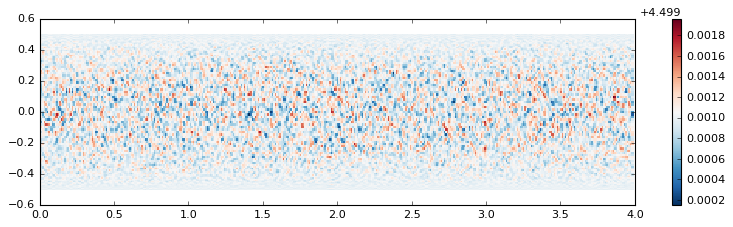

In [14]:
fig, axis = plt.subplots(figsize=(12,3))
pT = axis.pcolormesh(xm, zm, T['g'].T, cmap='RdBu_r');
plt.colorbar(pT)

In [18]:
# Initial timestep
dt = 0.125

In [19]:
# Integration parameters
solver.stop_sim_time = 25
solver.stop_wall_time = 30 * 70.
solver.stop_iteration = np.inf

## Exportar datos a archivo HDF5

In [20]:
# Analysis
snapshots = solver.evaluator.add_file_handler('grad_T', sim_dt=0.25, max_writes=100)
snapshots.add_system(solver.state)

## CFL

In [21]:
# CFL
CFL = flow_tools.CFL(solver, initial_dt=dt, cadence=10, safety=1,
                     max_change=1.5, min_change=0.5, max_dt=0.125, threshold=0.05)
CFL.add_velocities(('u', 'w'))

# Flow properties

In [22]:
solver.get_wall_time()

1497291045.262929

In [23]:
flow = flow_tools.GlobalFlowProperty(solver, cadence=10)
flow.add_property("sqrt(u*u + w*w) / R", name='Re')

## Main loop

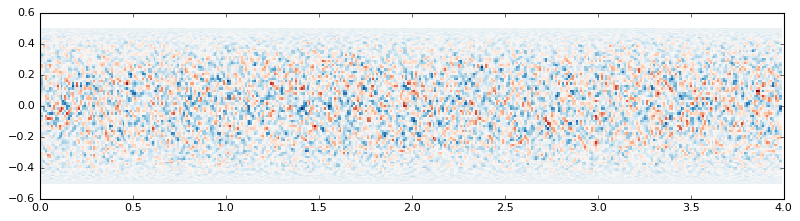

In [24]:
# Lo modifico para que grafique conforme iterando.
x = domain.grid(0,scales=domain.dealias)
z = domain.grid(1,scales=domain.dealias)
xm, zm = np.meshgrid(x,z)
fig, axis = plt.subplots(figsize=(12,3))
p = axis.pcolormesh(xm, zm, T['g'].T, cmap='RdBu_r');

In [25]:
solver.ok

True

In [26]:
try:
    logger.info('Starting loop')
    start_time = time.time()
    while solver.ok:
        #print("hola")
        dt = CFL.compute_dt()
        dt = solver.step(dt)
        if (solver.iteration-1) % 10 == 0:
            # Update plot of scalar field
            logger.info('Iteration: %i, Time: %e, dt: %e' %(solver.iteration, solver.sim_time, dt))
            logger.info('Max Re = %f' %flow.max('Re'))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    end_time = time.time()
    logger.info('Iterations: %i' %solver.iteration)
    logger.info('Sim end time: %f' %solver.sim_time)
    logger.info('Run time: %.2f sec' %(end_time-start_time))
    logger.info('Run time: %f cpu-hr' %((end_time-start_time)/60/60*domain.dist.comm_cart.size))


2017-06-12 13:10:52,160 __main__ 0/1 INFO :: Starting loop
2017-06-12 13:10:52,516 __main__ 0/1 INFO :: Iteration: 1, Time: 1.250000e-01, dt: 1.250000e-01
2017-06-12 13:10:52,516 __main__ 0/1 INFO :: Max Re = 0.000000
2017-06-12 13:10:55,251 __main__ 0/1 INFO :: Iteration: 11, Time: 1.375000e+00, dt: 1.250000e-01
2017-06-12 13:10:55,251 __main__ 0/1 INFO :: Max Re = 0.000971
2017-06-12 13:10:57,710 __main__ 0/1 INFO :: Iteration: 21, Time: 2.625000e+00, dt: 1.250000e-01
2017-06-12 13:10:57,712 __main__ 0/1 INFO :: Max Re = 0.001302
2017-06-12 13:11:00,458 __main__ 0/1 INFO :: Iteration: 31, Time: 3.875000e+00, dt: 1.250000e-01
2017-06-12 13:11:00,459 __main__ 0/1 INFO :: Max Re = 0.001499
2017-06-12 13:11:02,925 __main__ 0/1 INFO :: Iteration: 41, Time: 5.125000e+00, dt: 1.250000e-01
2017-06-12 13:11:02,926 __main__ 0/1 INFO :: Max Re = 0.001633
2017-06-12 13:11:05,835 __main__ 0/1 INFO :: Iteration: 51, Time: 6.375000e+00, dt: 1.250000e-01
2017-06-12 13:11:05,837 __main__ 0/1 INFO :: 

# Análisis

In [28]:
T.shape

(100, 256, 64)

In [29]:
def extraer_datos(nombre_h5):

    with h5py.File(nombre_h5, flag ='r') as hdf:
        base_items = list(hdf.items())
        print(base_items, '\n')
        tasks = hdf.get('tasks')
        tasks_items = list(tasks.items())
        print(tasks_items)

        T = np.array(tasks.get('T'))
        print(T.shape)

        ρ = np.array(tasks.get('ρ'))
        print(ρ.shape)
        
    return T, ρ

In [30]:
def animar_dedalus(xm, ym, S, CMAP):
    fig, axis = plt.subplots(figsize=(12,3))
    p = axis.pcolormesh(xm, ym, S[0,:,:].T, cmap=CMAP)

    def init():
                print('update init')
                p.set_array(np.ravel(S[0,:-1,:-1].T))
                return p

    def update(frame):
        p.set_array(np.ravel(S[frame, :-1, :-1].T))
        return p

    anim = animation.FuncAnimation(fig, update, frames= [i for i in range(1,len(S))], init_func=init,  blit = False)
    plt.show()
    return anim

In [31]:
T_dat , ρ_dat = extraer_datos('grad_T/grad_T_s1/grad_T_s1_p0.h5')

[('scales', <HDF5 group "/scales" (10 members)>), ('tasks', <HDF5 group "/tasks" (8 members)>)] 

[('p', <HDF5 dataset "p": shape (100, 256, 64), type "<f8">), ('T', <HDF5 dataset "T": shape (100, 256, 64), type "<f8">), ('ρ', <HDF5 dataset "ρ": shape (100, 256, 64), type "<f8">), ('u', <HDF5 dataset "u": shape (100, 256, 64), type "<f8">), ('w', <HDF5 dataset "w": shape (100, 256, 64), type "<f8">), ('Tz', <HDF5 dataset "Tz": shape (100, 256, 64), type "<f8">), ('uz', <HDF5 dataset "uz": shape (100, 256, 64), type "<f8">), ('wz', <HDF5 dataset "wz": shape (100, 256, 64), type "<f8">)]
(100, 256, 64)
(100, 256, 64)


In [32]:
T_dat[0,:,:].shape

(256, 64)

In [33]:
nx, nz = T_dat[0,:,:].shape
x_plot, z_plot = np.mgrid[slice(0, Lx, Lx/nx), slice(0, Lz, Lz/nz)]

In [37]:
x_plot.shape

(256, 64)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

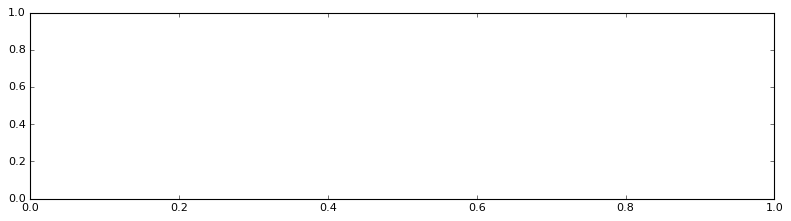

In [35]:
fig, axis = plt.subplots(figsize=(12,3))
p = axis.pcolormesh(x_plot, z_plot, T['g'].T, cmap='RdBu_r');
plt.colorbar(p)

update init


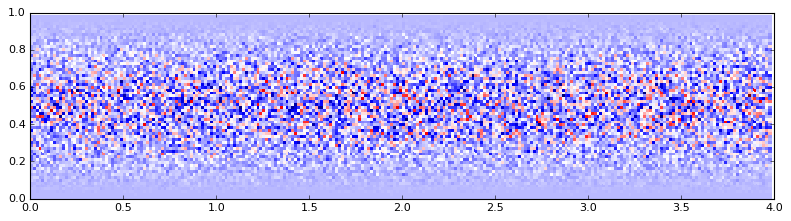

update init


In [43]:
anima = animar_dedalus(x_plot, z_plot, T_dat, 'seismic')
mywriter = animation.FFMpegWriter()
anima.save('T_grad.mp4',writer=mywriter, fps=30)

update init


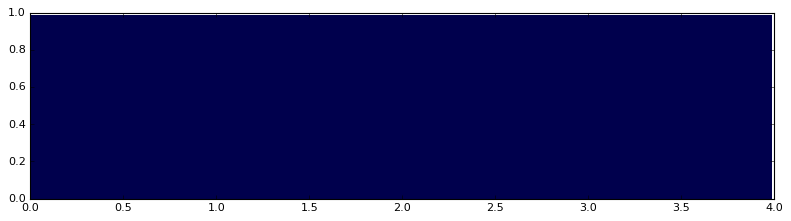

update init


In [44]:
ima = animar_dedalus(x_plot, z_plot, ρ_dat, 'seismic')
mywriter = animation.FFMpegWriter()
anima.save('rho_grad.mp4',writer=mywriter, fps=30)